Species: ['X', 'complex_Y_2x_Z_', 'Y', 'complex_X_2x_Y_Z_', 'complex_X_2x_Z_', 'complex_Y_2x_', 'complex_X_Y_2x_Z_', 'Z', 'complex_X_2x_']

Original System:
dX/dt = -2.0*X**2*kb__ - X*complex_Y_2x_Z_*kb__ + 2.0*complex_X_2x_*ku__ + complex_X_Y_2x_Z_*ku__
dcomplex_Y_2x_Z_/dt = -X*complex_Y_2x_Z_*kb__ + Z*complex_Y_2x_*kb__ + complex_X_Y_2x_Z_*ku__ - complex_Y_2x_Z_*ku__
dY/dt = -2.0*Y**2*kb__ - Y*complex_X_2x_Z_*kb__ + complex_X_2x_Y_Z_*ku__ + 2.0*complex_Y_2x_*ku__
dcomplex_X_2x_Y_Z_/dt = Y*complex_X_2x_Z_*kb__ - complex_X_2x_Y_Z_*ku__
dcomplex_X_2x_Z_/dt = -Y*complex_X_2x_Z_*kb__ + Z*complex_X_2x_*kb__ + complex_X_2x_Y_Z_*ku__ - complex_X_2x_Z_*ku__
dcomplex_Y_2x_/dt = Y**2*kb__ - Z*complex_Y_2x_*kb__ - complex_Y_2x_*ku__ + complex_Y_2x_Z_*ku__
dcomplex_X_Y_2x_Z_/dt = X*complex_Y_2x_Z_*kb__ - complex_X_Y_2x_Z_*ku__
dZ/dt = -Z*complex_X_2x_*kb__ - Z*complex_Y_2x_*kb__ + complex_X_2x_Z_*ku__ + complex_Y_2x_Z_*ku__
dcomplex_X_2x_/dt = X**2*kb__ - Z*complex_X_2x_*kb__ - complex_X_2x_*ku__

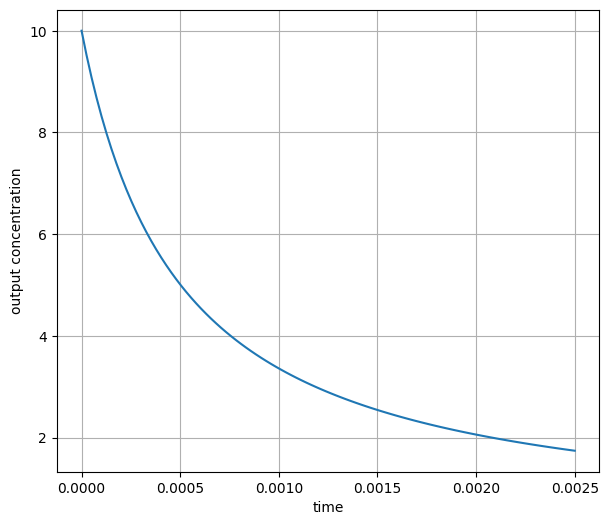

In [38]:
from autoreduce.converters import load_sbml
from sympy import Symbol
import numpy as np

# Load the CRN
sys = load_sbml("example6.xml", outputs = "X")

# Set initial conditions
x0_dict = {"X": 10}
for x, x_ic in x0_dict.items():
    curr_ind = sys.x.index(Symbol(x))
    sys.x_init[curr_ind] = x_ic

# Print species
print("Species:", [str(s) for s in sys.x])

# Print original system ODEs
print("\nOriginal System:")
for i, eq in enumerate(sys.f):
    print(f"d{sys.x[i]}/dt = {eq}")

from autoreduce.utils import get_ODE
import matplotlib.pyplot as plt 
import numpy as np 

species_names = [str(s) for s in sys.x]

timepoints_ode = np.linspace(0, 0.0025, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T  
plt.figure(figsize = (7,6))

full_model = np.transpose(np.array(sys.C)@sol)
plt.plot(timepoints_ode, full_model)
plt.xlabel('time')
plt.ylabel('output concentration')
plt.grid(True)
plt.show()















In [40]:
X_t = np.transpose(np.array(sys.C @ sol))
min_X = X_t.min()
max_X = X_t.max()

print(f"min value (concentration) of X during simulation: {min_X}")
print(f"max value (concentration) of X during simulation: {max_X}\n")


# the minimum value of the concentration of X is 1.6659829804130881

# now we have to use pacti to show this is true! assumption/guarantee time!

from pacti.contracts import PolyhedralIoContract

# suppose we know:
# the input assumption: X starts >=10
# the simulation guarantees: X stays >= 2
# even though we know that the min concentration of X is less than 2 actually.

contract1 = PolyhedralIoContract.from_dict({
    # assumptions = what we BELIEVE the environment or initial conditions will provide 
    # guarantees = what the system promises to do under those assumptions 
    # basically "if the assumptions are true, then the system guarantees these behaviors"

    # x_output >= 1.741
    # x_output <= x_input 
    #our output is greater than 1.741 but less than our input (10)
    "assumptions": [{"coefficients": {"x_input": -1}, "constant": -max_X}],  
    # our concentration of x (10) is assumed to be greater than or equal to 10
    "guarantees": [{"coefficients": {"x_output": -1}, "constant": -min_X},
    {"coefficients": {"x_output": 1, "x_input": -1}, "constant": 0}],     
    # if this is true, then our output will be greater than or equal to ~1.741
    "input_vars": ["x_input"],
    "output_vars": ["x_output"]
}) 

# contract2 = PolyhedralIoContract.from_dict({
#     "assumptions": [{"coefficients": {"x_input": -1}, "constant": -max_X}],    # same assumption
#     "guarantees": [{"coefficients": {"x_output": -1}, "constant": -1}],      # x >= 1
#     "input_vars": ["x_input"],
#     "output_vars": ["x_output"]
# })


print("contract (1) created:")
print(contract1)


# print("contract (2) created:") 
# print(contract2)

from pacti.utils.plots import plot_guarantees 
from pacti.iocontract import Var

sol = sys_ode.solve_system()
x_output_data = X_t[:, 0]  # extract x_output time series

fig = plot_guarantees(
    contract=contract1,
    x_var=Var("x_input"),
    y_var=Var("x_output"),
    var_values={},  # no fixed vars needed
    x_lims=(8, 15),  # adjust as needed
    y_lims=(0, 15)
)

import matplotlib.pyplot as plt

# Plot the simulation result as points at x_input=10
plt.scatter([10] * len(x_output_data), x_output_data, color="blue", label="Simulated x_output")

plt.legend()
plt.xlabel("x_input")
plt.ylabel("x_output")
plt.title("guarantee (shaded region) vs. simulated x_output")
plt.grid(True)
plt.show()




ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 9)